In [8]:
import backtrader as bt
import datetime

In [40]:
# Create a Stratey
class TestStrategy(bt.Strategy):
    params = (
        ('exitbars', 5),
    )

    def log(self, txt, dt=None):
        ''' Logging function fot this strategy'''
        dt = dt or self.datas[0].datetime.date(0)
        print('%s, %s' % (dt.isoformat(), txt))

    def __init__(self):
        # Keep a reference to the "close" line in the data[0] dataseries
#         self.dataclose = self.datas[0].close
        self.datanames = self.getdatanames()
        self.bar_executed = dict(zip(self.datanames, [0]*len(self.datanames)))

        # To keep track of pending orders and buy price/commission
        self.order = dict(zip(self.datanames, [None]*len(self.datanames)))
        self.buyprice = None
        self.buycomm = None

    def notify_order(self, order):
        if order.status in [order.Submitted, order.Accepted]:
            # Buy/Sell order submitted/accepted to/by broker - Nothing to do
            return

        # Check if an order has been completed
        # Attention: broker could reject order if not enough cash
        if order.status in [order.Completed]:
            if order.isbuy():
                self.log(
                    'BUY EXECUTED, Price: %.2f, Cost: %.2f, Comm %.2f' %
                    (order.executed.price,
                     order.executed.value,
                     order.executed.comm))

                self.buyprice = order.executed.price
                self.buycomm = order.executed.comm
            else:  # Sell
                self.log('SELL EXECUTED, Price: %.2f, Cost: %.2f, Comm %.2f' %
                         (order.executed.price,
                          order.executed.value,
                          order.executed.comm))

            self.bar_executed[order.data._name] = len(self)

        elif order.status in [order.Canceled, order.Margin, order.Rejected]:
            self.log('Order Canceled/Margin/Rejected')

        self.order[order.data._name] = None

    def notify_trade(self, trade):
        if not trade.isclosed:
            return

        self.log('OPERATION PROFIT, GROSS %.2f, NET %.2f' %
                 (trade.pnl, trade.pnlcomm))

    def next(self):
        # Simply log the closing price of the series from the reference
        for name in self.datanames:
            self.log('%s, Close, %.2f' % (name, self.dnames[name].close[0]))        
        
        for name in self.datanames:
            if self.order[name]:
                continue
            
            data = self.dnames[name]
            
            if not self.getpositionbyname(name):
                # Not yet ... we MIGHT BUY if ...
                if data.close[0] < data.close[-1]:
                        # current close less than previous close

                        if data.close[-1] < data.close[-2]:
                            # previous close less than the previous close

                            # BUY, BUY, BUY!!! (with default parameters)
                            self.log('%s, BUY CREATE, %.2f' % (name, data.close[0]))

                            # Keep track of the created order to avoid a 2nd order
                            self.order[name] = self.buy(data=data)

            else:

                # Already in the market ... we might sell
                if len(self) >= (self.bar_executed[name] + self.params.exitbars):
                    # SELL, SELL, SELL!!! (with all possible default parameters)
                    self.log('%s, SELL CREATE, %.2f' % (name, data.close[0]))

                    # Keep track of the created order to avoid a 2nd order
                    self.order[name] = self.sell(data=data)

In [41]:
# Create a cerebro entity
cerebro = bt.Cerebro()

# Add a strategy
cerebro.addstrategy(TestStrategy)

# Create a Data Feed
data0 = bt.feeds.GenericCSVData(
    dataname="C://Users//emara//Desktop//Stocks//a.us.txt",
    # Do not pass values before this date
    fromdate=datetime.datetime(1999, 11, 10),
    # Do not pass values before this date
    todate=datetime.datetime(2002, 12, 20),
    # Do not pass values after this date
    dtformat=("%Y-%m-%d"),
    datetime = 0,
    open=1,
    high=2,
    low=3,
    close=4,
    volume=5,
    openinterest=-1,
    reverse=False)

data1 = bt.feeds.GenericCSVData(
    dataname="C://Users//emara//Desktop//Stocks//aa.us.txt",
    # Do not pass values before this date
    fromdate=datetime.datetime(1999, 11, 10),
    # Do not pass values before this date
    todate=datetime.datetime(2002, 12, 20),
    # Do not pass values after this date
    dtformat=("%Y-%m-%d"),
    datetime = 0,
    open=1,
    high=2,
    low=3,
    close=4,
    volume=5,
    openinterest=-1,
    reverse=False)

data1.plotinfo.plotmaster = data0
data1.plotinfo.sameaxis = True

# Add the Data Feed to Cerebro
cerebro.adddata(data0, name = "data0")
cerebro.adddata(data1, name = "data1")

# Set our desired cash start
cerebro.broker.setcash(100000.0)

# Add a FixedSize sizer according to the stake
cerebro.addsizer(bt.sizers.FixedSize, stake=10)

# Set the commission - 0.1% ... divide by 100 to remove the %
cerebro.broker.setcommission(commission=0.001)

# Print out the starting conditions
print('Starting Portfolio Value: %.2f' % cerebro.broker.getvalue())

# Run over everything
cerebro.run()

# Print out the final result
print('Final Portfolio Value: %.2f' % cerebro.broker.getvalue())

Starting Portfolio Value: 100000.00
1999-11-18, data0, Close, 29.70
1999-11-18, data1, Close, 64.08
1999-11-18, data1, BUY CREATE, 64.08
1999-11-19, BUY EXECUTED, Price: 64.97, Cost: 649.74, Comm 0.65
1999-11-19, data0, Close, 27.26
1999-11-19, data1, Close, 65.29
1999-11-22, data0, Close, 29.70
1999-11-22, data1, Close, 66.13
1999-11-23, data0, Close, 27.00
1999-11-23, data1, Close, 66.65
1999-11-24, data0, Close, 27.72
1999-11-24, data1, Close, 65.77
1999-11-26, data0, Close, 27.81
1999-11-26, data1, Close, 66.77
1999-11-29, data0, Close, 28.43
1999-11-29, data1, Close, 66.52
1999-11-29, data1, SELL CREATE, 66.52
1999-11-30, SELL EXECUTED, Price: 66.52, Cost: 649.74, Comm 0.67
1999-11-30, OPERATION PROFIT, GROSS 15.49, NET 14.18
1999-11-30, data0, Close, 28.48
1999-11-30, data1, Close, 67.02
1999-12-01, data0, Close, 28.99
1999-12-01, data1, Close, 68.38
1999-12-02, data0, Close, 29.79
1999-12-02, data1, Close, 71.05
1999-12-03, data0, Close, 30.04
1999-12-03, data1, Close, 72.85
199

2000-03-13, data1, Close, 69.94
2000-03-13, data0, BUY CREATE, 88.60
2000-03-14, BUY EXECUTED, Price: 89.78, Cost: 897.82, Comm 0.90
2000-03-14, data0, Close, 81.94
2000-03-14, data1, Close, 62.89
2000-03-15, data0, Close, 77.12
2000-03-15, data1, Close, 65.77
2000-03-15, data1, SELL CREATE, 65.77
2000-03-16, SELL EXECUTED, Price: 66.69, Cost: 672.10, Comm 0.67
2000-03-16, OPERATION PROFIT, GROSS -5.17, NET -6.51
2000-03-16, data0, Close, 79.69
2000-03-16, data1, Close, 70.74
2000-03-17, data0, Close, 81.76
2000-03-17, data1, Close, 66.42
2000-03-20, data0, Close, 76.79
2000-03-20, data1, Close, 67.33
2000-03-21, data0, Close, 77.63
2000-03-21, data1, Close, 70.20
2000-03-21, data0, SELL CREATE, 77.63
2000-03-22, SELL EXECUTED, Price: 76.66, Cost: 897.82, Comm 0.77
2000-03-22, OPERATION PROFIT, GROSS -131.23, NET -132.89
2000-03-22, data0, Close, 80.62
2000-03-22, data1, Close, 68.65
2000-03-23, data0, Close, 80.80
2000-03-23, data1, Close, 71.39
2000-03-24, data0, Close, 81.01
2000-03

2001-10-23, data1, SELL CREATE, 70.47
2001-10-24, SELL EXECUTED, Price: 16.02, Cost: 155.26, Comm 0.16
2001-10-24, SELL EXECUTED, Price: 70.67, Cost: 668.12, Comm 0.71
2001-10-24, OPERATION PROFIT, GROSS 4.92, NET 4.60
2001-10-24, OPERATION PROFIT, GROSS 38.61, NET 37.24
2001-10-24, data0, Close, 16.35
2001-10-24, data1, Close, 70.93
2001-10-25, data0, Close, 16.29
2001-10-25, data1, Close, 72.68
2001-10-26, data0, Close, 16.43
2001-10-26, data1, Close, 72.83
2001-10-29, data0, Close, 15.48
2001-10-29, data1, Close, 71.10
2001-10-30, data0, Close, 14.99
2001-10-30, data1, Close, 69.26
2001-10-30, data0, BUY CREATE, 14.99
2001-10-30, data1, BUY CREATE, 69.26
2001-10-31, BUY EXECUTED, Price: 15.12, Cost: 151.20, Comm 0.15
2001-10-31, BUY EXECUTED, Price: 68.90, Cost: 689.04, Comm 0.69
2001-10-31, data0, Close, 15.03
2001-10-31, data1, Close, 67.38
2001-11-01, data0, Close, 15.46
2001-11-01, data1, Close, 68.33
2001-11-02, data0, Close, 15.73
2001-11-02, data1, Close, 69.44
2001-11-05, da

<IPython.core.display.Javascript object>


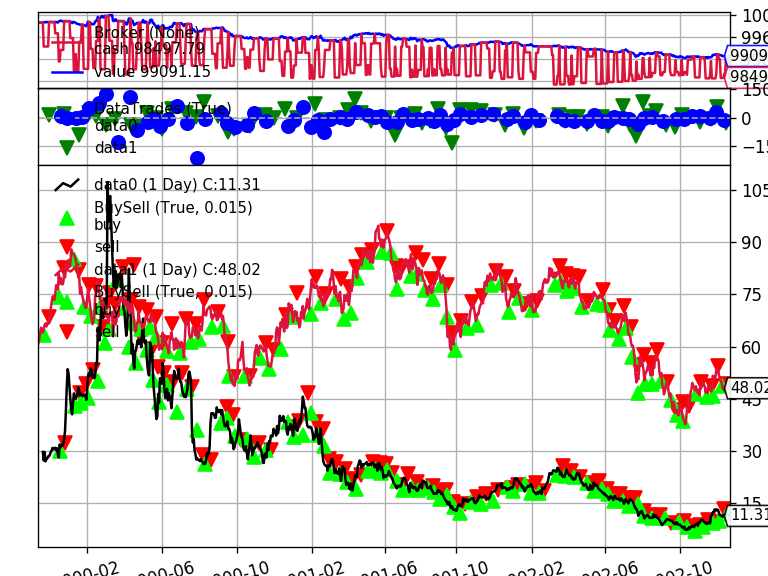

[[<matplotlib.figure.Figure at 0x24497661da0>]]

In [42]:
cerebro.plot(numfigs = 1)

In [51]:
data0.open[0]

11.205